<a href="https://colab.research.google.com/github/mohanrajmit/DL-Training/blob/master/dcgan_color_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np

import os

Its always a good practice to check the current version of TensorFlow...

In [5]:
print(tf.version.VERSION)

2.8.2


## Data

We will train the DCGAN on a dataset called [Clothing & Models](https://www.kaggle.com/dqmonn/zalando-store-crawl) from Kaggle, which is a collection of clothing pieces, scraped from Zalando.com. 

Here is how to download Kaggle data from Colab:
* Navigate to https://www.kaggle.com. 
* Go to the [account tab](https://www.kaggle.com/me/account)  of your user profile. 
* Select "Create API Token" which triggers the download of kaggle.json, a file containing your API credentials. 
* Enter your username and Kaggle key in the cell below.

In [6]:
os.environ['KAGGLE_USERNAME']="mohanraj4072" 
os.environ['KAGGLE_KEY']="2f0e5f537058775b894b214de6604785"

In [7]:
# download kaggle dataset to 'datasets/' path
!kaggle datasets download -d dqmonn/zalando-store-crawl -p datasets

100% 2.24G/2.24G [00:19<00:00, 149MB/s]
100% 2.24G/2.24G [00:19<00:00, 122MB/s]


In [8]:
!unzip datasets/zalando-store-crawl.zip -d datasets/

Streaming output truncated to the last 5000 lines.
  inflating: datasets/zalando/zalando/sweatshirt-female/NAA21J00K-K11@8.jpg  
  inflating: datasets/zalando/zalando/sweatshirt-female/NAA21J00L-C11@8.jpg  
  inflating: datasets/zalando/zalando/sweatshirt-female/NAA21J00L-H11@7.1.jpg  
  inflating: datasets/zalando/zalando/sweatshirt-female/NAA21J00L-Q11@8.jpg  
  inflating: datasets/zalando/zalando/sweatshirt-female/NAA21J00M-G11@13.jpg  
  inflating: datasets/zalando/zalando/sweatshirt-female/NAA21J00N-C11@10.jpg  
  inflating: datasets/zalando/zalando/sweatshirt-female/NAA21J00O-Q11@9.jpg  
  inflating: datasets/zalando/zalando/sweatshirt-female/NAA21J00P-N11@5.1.jpg  
  inflating: datasets/zalando/zalando/sweatshirt-female/NAA21J00Q-Q11@10.jpg  
  inflating: datasets/zalando/zalando/sweatshirt-female/NAA21J00U-A11@4.jpg  
  inflating: datasets/zalando/zalando/sweatshirt-female/NAA21J00V-P11@4.jpg  
  inflating: datasets/zalando/zalando/sweatshirt-female/NE221J007-Q11@1.1.jpg  
  in

In [9]:
zalando_data_dir = "/content/datasets/zalando/zalando"

In [10]:
train_images = tf.keras.utils.image_dataset_from_directory(
    zalando_data_dir, label_mode=None, image_size=(64, 64), batch_size=32
)

Found 16180 files belonging to 1 classes.


### Visualization

I always like to visualize the training data to get an idea of what the images look like. 

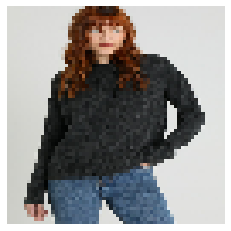

In [11]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")
plt.axis("off")
plt.imshow(random_image)
plt.show()

### Preprocessing

In [12]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

## The Generator

Define the generator model architecture with the Keras `Sequential` API.

Use `ReLU` except for the last layer which has `tanh` as the activation.

The job of the generator is to make images, to do so in DCGAN, we feed random noise as input to the generator and upsample till the desired image size becomes 64x64x3.

In [13]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3 # UPDATED from 1

In [14]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name='generator')

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # layers.LeakyReLU(alpha=0.2),

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((8, 8, 512)))

    # upsample to 16x16: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 32x32: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 64x64: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    # return the generator model
    return model

In [15]:
# build the generator model
generator = build_generator() 

In [16]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      524416    
 ranspose)                                               

## The Discriminator

Define the discriminator model architecture with the Keras `Sequential` API

In [17]:
def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputting a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [18]:
# build the discriminator model
discriminator = build_discriminator(64, 64, 3) 

In [19]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

## DCGAN

### Define the DCGAN class
Subclass `keras.Model` and override `train_step()` to implement the DCGAN architecture. This is where the magic happens and the heart of the DCGAN implementation. [TODO: explain minimax objective function in tutorial, along with visual illustrations]

In [20]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            # UPDATED: apply one-sided label smoothing to real labels
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) 
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            # UPDATED: add random noise to fake labels - not needed
            # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels)) 
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

### Use Keras Callback to monitor training

The nice thing about overriding `train_step()` of `keras.Model()` is that we can subclass `Callback` to monitor our DCGAN training.

I use the seed noise to create images (with the generator model) throughout the training to see the progress of the generator is making. Also saved the generator model at the end of the training which could potentially be used for inference later.

In [21]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

### The DCGAN model - putting it together

In [22]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

## Compile DCGAN

Compile the dcgan model, use the `Adam` optimizer, learning rate of 0.0002, and the **Binary Cross Entropy** as recommended by the paper. 

In later GAN tutorials, you will learn that we can use other loss functions for other GAN variants.

In [23]:
D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0003 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

## Train DCGAN
Now we simply call `model.fit()` to traing the dcgan model!

Epoch 1/50
506/506 [==============================] - ETA: 0s - d_loss: 0.6293 - g_loss: 2.8470

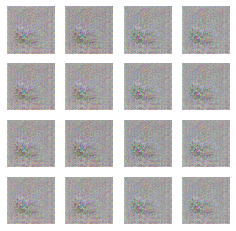

506/506 [==============================] - 94s 152ms/step - d_loss: 0.6293 - g_loss: 2.8470
Epoch 2/50
 81/506 [===>..........................] - ETA: 1:02 - d_loss: 0.6044 - g_loss: 3.3590

In [ ]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])